# Imports

In [1]:
import sys  
sys.path.insert(1, '..')

In [2]:
from deepview import DeepView
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader
import time
import os
# from splinecamC import splinecam
import splinecam
import seaborn as sns
from tqdm.notebook import tqdm
from src.utils_train import train, val_step, train_one, val_step_one
from sklearn.datasets import make_moons, make_circles,make_classification
from sklearn.model_selection import train_test_split, KFold
import matplotlib.colors as mcolors
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

<unknown>:3: SyntaxWarning: invalid escape sequence '\i'


# REPRODUCIBILITY

In [3]:
seed = 15
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# SETUP

In [4]:
TRAIN = True
ONE_TRAIN = True
ONE_NODE_OUT = True

act_func = F.sigmoid if ONE_NODE_OUT else lambda y: F.softmax(y, dim=1)
dir = "results/"
if not os.path.isdir(dir): os.mkdir(dir)
train, val_step = (train_one, val_step_one) if ONE_NODE_OUT else (train, val_step)

In [5]:

def make_dataloader(generator,config,
                 noise=0.05,seed=15,
                 batch_size=128):

    '''
    Generates a dataloader with config, it can run a generator or use make_classification function
    '''    

    if config["name"] == "Spiral":
        X,y = generator(n_samples=config["n_samples"], shuffle=False,
                        noise=noise, random_state=seed)#rotations=.5
    else:
       X, y = make_classification(config["n_samples"], n_features= config["n_features"], n_classes=config["n_classes"], random_state=seed,\
                                  n_informative=config["n_informative"], shift=0,n_redundant=0, n_clusters_per_class=2, class_sep = 2, shuffle=False)
        
    inputs = torch.hstack([
        torch.Tensor(X[:,:]),torch.Tensor(y[...,None])
    ])

    dataloader = torch.utils.data.DataLoader(inputs,
                                             batch_size=batch_size,
                                             pin_memory=True,
                                             shuffle=True)
    return dataloader


def make_spiral(n_samples,
                shuffle=False,
                noise=1,
                random_state=0,
                rotations=1.5,
                ):
  '''
  Make spiral dataset
  '''

  N = n_samples
  pi = rotations*np.pi
  theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

  r_a = 2*theta + pi
  data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
  x_a = data_a + np.random.randn(N,2)*1

  r_b = -2*theta - pi
  data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
  x_b = data_b + np.random.randn(N,2)*1

  res_a = np.append(x_a, np.zeros((N,1)), axis=1)
  res_b = np.append(x_b, np.ones((N,1)), axis=1)

  res = np.append(res_a, res_b, axis=0)
  np.random.shuffle(res)

  return res[:,:2],res[:,-1]

In [6]:
experiment_config = {"Custom": {"name": "Custom",
                                "n_features":2,
                                "n_samples":2000,
                                "n_classes":2,
                                "n_informative":2},
                     "Spiral":{"name": "Spiral",
                               "n_features":2,
                                "n_samples":10000,
                                "n_classes":2,
                                "n_informative":2},
                     "Three":{"name": "Three",
                              "n_features":3,
                                "n_samples":2000,
                                "n_classes":2,
                                "n_informative":3}}
# Experiment selection
exp_name = "Spiral"
select_config = experiment_config[exp_name]
n_features = select_config["n_features"]
n_informative = select_config["n_informative"]
n_classes = select_config["n_classes"]
n_samples = select_config["n_samples"]

In [7]:
# prepare data
# dataloader = make_dataloader(make_moons,10000)
# dataloader = make_dataloader(make_circles,10000)
dataloader = make_dataloader(make_spiral,select_config)

tot_idx = range(n_samples)
train_idx, test_idx = train_test_split(tot_idx, test_size = 0.15, random_state=seed)
X = dataloader.__dict__['dataset'][:,:-1]
y = dataloader.__dict__['dataset'][:,-1]
# Train set
y_train = y[train_idx]
# Test set HOLDOUT SET
y_test =y[test_idx]

Text(0.5, 1.0, 'Data')

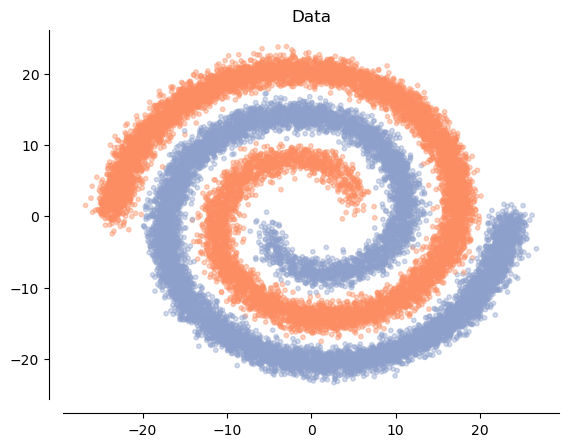

In [8]:
# custom cmap definition
custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

# Display dataset
plt.rcParams['figure.dpi'] = 100
fig = plt.figure()
ax = fig.add_subplot(projection=("3d" if n_features == 3 else None))
if n_features == 3: ax.view_init(azim=-40 , elev = 25)
if n_features == 3:
    ax.view_init(azim=-50 , elev = 25)
color = dataloader.__dict__['dataset'][:,-1].numpy().astype(np.int8)
ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
            c = color, s=10, alpha=.4, cmap=custom_cmap)
sns.despine(offset=10)
ax.set_title("Data")

## NETWORK

In [9]:
# model definition
width = 10
depth = 5
activation_fn = torch.nn.ReLU ## torch.nn.LeakyReLU
device='cpu'
bias = True

# create model
def get_model():
	layers = [torch.nn.Flatten()]
	for i in range(depth):
		if i == 0:
			layers.append(torch.nn.Linear(np.prod(n_features), width))
			layers.append(activation_fn())
		elif i == depth - 1:
			layers.append(nn.Linear(int(width), 1 if ONE_NODE_OUT else n_classes))
		# elif i == depth - 2:
		#     layers.append(nn.MaxPool1d(2))
		else:
			layers.append(nn.Linear(width, width))
			layers.append(activation_fn())
	return nn.Sequential(*layers).to(device)

model = get_model()

# bias cant be none for splinecam library, hence we separately set it to zero
if not bias:
	for layer in model:
		if hasattr(layer,'bias'):
			layer.bias = torch.nn.Parameter(torch.zeros_like(layer.bias)+1e-6)

In [10]:
model.type

<bound method Module.type of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=1, bias=True)
)>

# TRAIN

In [11]:
# Single fold train
if ONE_TRAIN:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()#nn.BCEWithLogitsLoss()

    epochs = 200
    device = 'cuda'
    model = model.to(device)

    for epoch in tqdm(range(1, epochs + 1)):

        # train step
        val_acc = 0
        model.train()
        total_loss = 0
        for batch_idx, data in enumerate(dataloader, 1):
            model.type(torch.float32)
            # prep data
            
            data,target = data[:,:-1],data[:,-1:]
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            # calculate loss and perform backprop
            loss = criterion(output, target.view(-1,1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            y_pred_class = F.sigmoid(output).round() if ONE_NODE_OUT else torch.argmax(torch.softmax(output,dim=1),dim=1)
            val_acc += ((y_pred_class.view(-1) == target.flatten().view(-1)).sum().item()/len(target))

        # model.cuda()
        model.train()
        model.type(torch.float32)

        # print loss stats
        print("Epoch: {}, Loss: {}, Acc: {}".format(epoch, total_loss / len(dataloader), val_acc/(batch_idx+1)))   

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.6316078320430343, Acc: 0.6324663765822784
Epoch: 2, Loss: 0.5942751605799244, Acc: 0.6580795094936709
Epoch: 3, Loss: 0.5695966239188127, Acc: 0.6330102848101266
Epoch: 4, Loss: 0.5076927159242569, Acc: 0.6904667721518988
Epoch: 5, Loss: 0.39502646000521957, Acc: 0.7746242088607594
Epoch: 6, Loss: 0.24283916583866072, Acc: 0.8907733386075949
Epoch: 7, Loss: 0.13631907340352703, Acc: 0.9441257911392406
Epoch: 8, Loss: 0.062081633598371676, Acc: 0.9873912183544303
Epoch: 9, Loss: 0.03459742185985966, Acc: 0.9902096518987342
Epoch: 10, Loss: 0.023790087337326852, Acc: 0.9904074367088608
Epoch: 11, Loss: 0.019451803471418512, Acc: 0.9902096518987342
Epoch: 12, Loss: 0.016510319694354656, Acc: 0.9901602056962026
Epoch: 13, Loss: 0.014468137330559504, Acc: 0.9909513449367089
Epoch: 14, Loss: 0.012607130161219627, Acc: 0.9909018987341772
Epoch: 15, Loss: 0.012963699262921407, Acc: 0.9903085443037974
Epoch: 16, Loss: 0.01285391390934634, Acc: 0.9902096518987342
Epoch: 17, Los

## CROSS VALIDATION

In [12]:
#generatin the 10 fold data
folds = 10
NUM_EPOCHS = 15
device = "cuda"
if TRAIN and not ONE_TRAIN:
  
	kf = KFold(n_splits=folds)#,random_state=42, shuffle=True

	# Continue the training and validation of the model for all the other folds
	for i, (train_index, test_index) in tqdm(enumerate(kf.split(train_idx))):
		model = get_model().to(device)
		optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
		loss_fn =nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()

		# Keeping the split
		train_str = "train_"+str(i)
		val_str = "val_"+str(i)

		# Turn train and validation Datasets into DataLoaders
		ds_train = TensorDataset(X[train_idx][train_index].to(device), y_train[train_index].view(-1,1).to(device))
		ds_test = TensorDataset(X[train_idx][test_index].to(device), y_train[test_index].view(-1,1).to(device))
		trainloader = DataLoader(ds_train,batch_size=16,shuffle=True)
		validationloader = DataLoader(ds_test,batch_size=16)

		# Start the timer
		from timeit import default_timer as timer
		start_time = timer()
		# Train model
		model_results = train(model=model,
							train_dataloader=trainloader,
							val_dataloader=validationloader,
							optimizer=optimizer,
							loss_fn=loss_fn,
							epochs=NUM_EPOCHS,
							split=i,
							dir=dir)
		# End the timer and print out how long it took
		end_time = timer()
		print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")

		# Extract train and validation loss and accuracy at each epoch
		results = dict(list(model_results.items()))

		# Get the loss values of the results dictionary (training and validation)
		train_loss = results["train_loss"]
		val_loss = results["val_loss"]

		# Get the accuracy values of the results dictionary (training and validation)
		train_acc = results["train_acc"]
		val_acc = results["val_acc"]

		# Figure out how many epochs there were
		epochs = range(len(results["train_loss"]))
		
		# Save results in a csv
		results_df = pd.DataFrame(columns= ["train_loss","val_loss","train_acc","val_acc","epochs"])
		results_df["train_loss"] = train_loss
		results_df["val_loss"] = val_loss
		results_df["train_acc"] = train_acc
		results_df["val_acc"] = val_acc
		results_df["epochs"] = epochs
		path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
		results_df_name = f"{dir}/{path}"+str(i)+".csv"
		results_df.to_csv(results_df_name)

## TRAIN PERFORMANCES

In [13]:
if not ONE_TRAIN:
	results = []
	val_accuracies = np.zeros([10,1])
	path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
	for i in range(folds):
		results.append(pd.read_csv(f"{dir}/{path}{i}.csv"))
		val_accuracies[i] = np.max(results[i]["val_acc"])

	# Get the fold corresponding to the overall best
	index = np.argmax(val_accuracies)


	res = pd.concat(results)
	# res.replace([np.inf, -np.inf], np.nan)
	res = res.map(lambda x: np.nan if x in [np.inf, -np.inf] else x)
	len(results), index, val_accuracies

In [14]:
if not ONE_TRAIN:
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    sns.lineplot(data=res, x="epochs", y="train_loss", err_style="band", label="train", ax=axs[0])
    sns.lineplot(data=res, x="epochs", y="val_loss", err_style="band", label="val", ax=axs[0])
    sns.lineplot(data=res, x="epochs", y="train_acc", err_style="band", label="train", ax=axs[1])
    sns.lineplot(data=res, x="epochs", y="val_acc", err_style="band", label="val", ax=axs[1])
    sns.despine(offset=10)
    plt.tight_layout()


In [15]:
if not ONE_TRAIN:
    # Looking across all the best validation accuracies obtained from the ten folds
    val_accuracies = np.zeros([10,1])
    path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
    for i in range(folds):
        results_string = f"{dir}/{path}"+str(i)+".csv"
        val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])

    # Get the fold corresponding to the overall best
    index = np.argmax(val_accuracies)
    index

In [16]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location=torch.device("cuda"))
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model


In [17]:
# Holdout setup
x_holdout_tensor =  torch.tensor(X[test_idx], dtype=torch.float32).to(device)
y_binary_test_tensor = torch.tensor(y_test).to(device).view(-1,1)
ds_holdout=TensorDataset(x_holdout_tensor,y_binary_test_tensor)
holdout_loader = DataLoader(ds_holdout,batch_size=16)


/tmp/ipykernel_2821984/963514517.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_holdout_tensor =  torch.tensor(X[test_idx], dtype=torch.float32).to(device)
/tmp/ipykernel_2821984/963514517.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_binary_test_tensor = torch.tensor(y_test).to(device).view(-1,1)


In [18]:
if not ONE_TRAIN:
    val_accuracies = np.zeros([10,1])
    ck_path = "One_checkpoint_" if ONE_NODE_OUT else "checkpoint_"
    loss_fn = nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()
    for i in range(folds):
        model_string = f"{dir}/{ck_path}"+str(i)+".pth"
        model_cp = load_checkpoint(model_string)
        
        val_loss, val_accuracies[i], f1,_= val_step(model=model_cp.to(device),
                    dataloader=holdout_loader,
                    loss_fn=loss_fn)
        # val_accuracies[i] = val_acc
        print("ACCURACY: ", val_accuracies[i], "F1: ",f1)
    index = np.argmax(val_accuracies)
    index

## Loading best model

In [19]:
if not ONE_TRAIN:
	model_string = f"{dir}/{ck_path}"+str(index)+".pth"
	model_cp = load_checkpoint(model_string)
	model_cp.eval()
	model_cp.to(device)
	loss_fn = nn.CrossEntropyLoss().to(device) 
	print(model_cp)

	val_loss, val_acc, f1,_ = val_step(model=model_cp,
				dataloader=holdout_loader,
				loss_fn=loss_fn)

	print("\nACCURACY: ", val_acc, "\nF1: ",f1)
	model = model_cp


In [20]:
class_0_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==0)]
class_1_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==1)]
# class_2_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==2)]

## GPU IBS

In [ ]:
pred_bound = 1/2
get_class = lambda x: torch.round(x, decimals=0) if ONE_NODE_OUT else lambda x: torch.argmax(x, dim=1)
def IBS_gpu(bss, model, target_class_0, target_class_1, data, precision = 0.05, device = 'cuda', noise_mul = 2, max_iters = None, shuffle = False):
    '''
    Informed Baseline Search with a starting point, and a pool of targets computes the inner boundary (baselines) of a NN

    :param bss: starting point, can be a batch
    :param model: model to be investigated
    :param target_class_0/target_class_1: data idx of the target pool for class 0 and class 1
    :param data: input samples of the network, used to navigare in the feature space
    :param precision: precision of the baseline (.5-precision < predict(bs) < .5+precision needs to be met to consider baseline)
    :param device: device
    :param noise_mul: scalar factor to modify the step intensity
    :param max_iters: max number of iteration until break
    :param shuffle: True for shuffle the target pool order


    :returns baselines: baselines computed
    '''
    bss.to(device)
    model.to(device)
    model.eval()
    shape_offset = (len(bss.shape[1:]))
    low_b = np.min([len(target_class_0), len(target_class_1)])
    #shuffle targets
    if shuffle:
        np.random.shuffle(target_class_0)
        np.random.shuffle(target_class_1)
    #setup target pools
    target_classes = torch.stack([torch.tensor(target_class_0[:low_b]),torch.tensor(target_class_1[:low_b])], dim=1).to(device)
    #pool idx counter
    iters_count = torch.zeros((bss.shape[0],2),dtype=torch.int64, device=device)
    baselines = []
    iteration = 0

    while(bss.shape[0]>0 and (iteration < max_iters if not max_iters is None else True)):
        #computing prediction
        outs = model(bss)
        softmax_preds = act_func(outs)
        preds = softmax_preds[:,0]
        #Baseline check and extraction
        cond = ((pred_bound-precision) < preds)  * (preds <(pred_bound+precision))
        baselines.extend([*[x.cpu() for x in bss[torch.where(cond)]]])
        bss = bss[torch.where(~cond)]
        # jump out if no more data 
        if all(cond):break
        #getting rid of baseline information
        iters_count = iters_count[torch.where(~cond)]
        #computing next step
        idxs = get_class(softmax_preds[torch.where(~ cond)]).type(torch.bool)
        new_idx = torch.zeros(bss.shape[0], dtype=torch.int32,device=device) 
        new_idx = target_classes[iters_count[torch.arange(idxs.shape[0]), (~ idxs).long().squeeze()] %low_b,(~ idxs).long().squeeze()].to(device)
        #update idx counter
        iters_count[torch.arange(idxs.shape[0]), (~ idxs).long().squeeze()] +=1
        #compute directions
        dirs = torch.tensor(data[new_idx.cpu()].clone().detach(), device=device, dtype=torch.float32).view(bss.shape)
        dirs =dirs- bss 
        #compute intensity
        multi = ((max_iters/2-iteration) / max_iters/2)*noise_mul
        pred_values =  softmax_preds[torch.where(~ cond)[0]].squeeze()
        intensity = torch.round(((pred_values-(1-pred_values))/2) * multi, decimals=5)
        intensity = abs(intensity)
        #step
        weighted_input = dirs*intensity.view(-1, *[1]*shape_offset)
        bss = bss + weighted_input
        iteration += 1
    
    print(bss.shape[0], iteration )
    del weighted_input, dirs, bss
    return torch.stack(baselines) if len(baselines)>0 else []




In [22]:
def inference_transf(x):
    """
    Setup input for model 
    """
    return torch.tensor(x, dtype=torch.float32, device=device).view(1,n_features)

Compute corrected classified samples

In [23]:
classified=[[],[]]
device = 'cuda'
model.to(device)
for i,x in enumerate( X):
    pred = act_func(model(inference_transf(x)))
    pred_idx = pred.round() if ONE_NODE_OUT else torch.argmax(pred, dim=1)
    classified[int(pred_idx)].append(i)

/tmp/ipykernel_2821984/1141288062.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32, device=device).view(1,n_features)


# Informed Baseline Search

To run `IBS_gpu` we need to setup a dataloader with data that we use for search baselines, the batchsize is crucial. Then we need *class pools*, here we use `classified` lists to identify the sample idx by class (we use idxs to save memory)

In [ ]:
temp = []
model.type(torch.float32)
data_ds = TensorDataset(torch.tensor(X.clone().detach(), requires_grad=False))
data_l = DataLoader(data_ds, batch_size=5096)
for d in tqdm(data_l):
    temp.extend(IBS_gpu(torch.tensor(d[0].clone().detach(), device="cuda", dtype=torch.float32).view(-1,n_features), model, classified[0], classified[1], data=X, precision = 0.01, device = 'cuda', noise_mul = 1/10, max_iters = 2000))
    torch.cuda.empty_cache()
bss = torch.stack(temp)

/tmp/ipykernel_2821984/2901947419.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_ds = TensorDataset(torch.tensor(X.clone().detach(), requires_grad=False))


  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_2821984/2901947419.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp.extend(IBS_gpu(torch.tensor(d[0].clone().detach(),device="cuda", dtype=torch.float32).view(-1,n_features), model, classified[0],classified[1], data=X, precision = 0.01, device = 'cuda', noise_mul = 1/10, max_iters = 2000))
/tmp/ipykernel_2821984/1407617271.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dirs = torch.tensor(data[new_idx.cpu()].clone().detach(), device=device, dtype=torch.float32).view(bss.shape)


0 412
0 412
0 409
0 412


In [25]:
bs_arr = bss.detach().cpu().numpy()

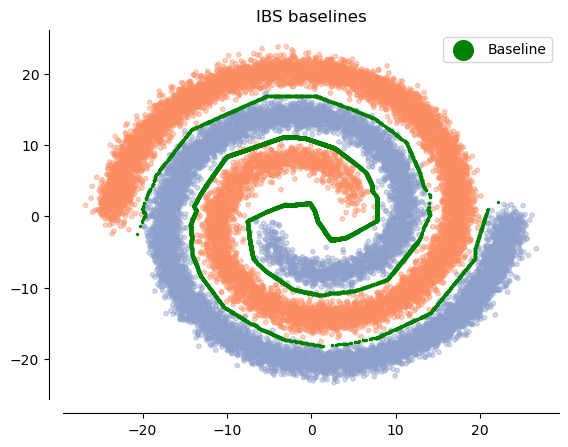

In [26]:
# data + baseline plot

fig = plt.figure()
ax = fig.add_subplot(projection=("3d" if n_features == 3 else None))
if n_features == 3:
    ax.view_init(azim=-50 , elev = 25)
color = dataloader.__dict__['dataset'][:,-1].numpy().astype(np.int8)
ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
            c = color, s=10, alpha=.4, cmap=custom_cmap)



ax.scatter(*bs_arr.T, zorder=10000000000, c='g', s=2, label="Baseline")

sns.despine(offset=10)
ax.set_title("IBS baselines")
ax.legend(*ax.get_legend_handles_labels(),markerscale=10)

# SPLINECAM

In [27]:
if n_features == 2:
    xlow,ylow= dataloader.__dict__['dataset'][:,:-1].min(0)[0].numpy()
    xhigh,yhigh = dataloader.__dict__['dataset'][:,:-1].max(0)[0].numpy()

    # ROI square domain at the input space
    
    domain = torch.tensor([
        [xlow,ylow],
        [xlow,yhigh],
        [xhigh,yhigh],
        [xhigh,ylow,],
        [xlow,ylow],
        
    ])

    T  = torch.eye(3)[:-1]
    # from adjustText import adjust_text
    model.cpu()
    model.eval()
    model.type(torch.float64)

    print('Wrapping model with SplineCam...')

    NN = splinecam.wrappers.model_wrapper(
        model,
        input_shape=(1,n_features),
        T = T,
        dtype = torch.float64,
        device = 'cpu'
    )

    # check .forward() and matmul operation equivalence

    flag =  NN.verify()
    assert flag

    # specify level set for output neuron, for db visualization
    thresh = 0.
    NN.layers[-1].Ab[:,-1] = NN.layers[-1].Ab[:,-1] + thresh

    print(domain.shape)
    # get partitions
    out_cyc,endpoints,Abw = splinecam.compute.get_partitions_with_db(domain,T,NN)


Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Wrapping layer 9...
torch.Size([5, 2])
Finding regions from first layer graph


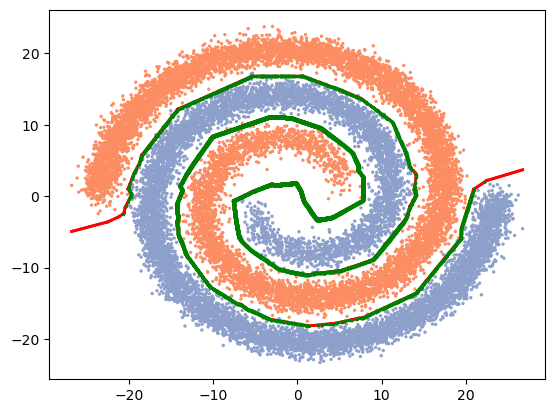

In [28]:
# data + baselines + SplineCAM partition plot
if n_features == 2:
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    for each in endpoints:
        if each is not None:
            ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=2)

    texts = []
    g_pred=[]
    k_pred=[]
    model.eval()
    for each in endpoints:
        if each is not None:
            ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=2, alpha=1)
            


    ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
                c = dataloader.__dict__['dataset'][:,-1].numpy(), s=2,
                cmap = custom_cmap)
    ax.scatter(*bs_arr[:,:n_features].T, zorder=10000000000, c='g', s=2, alpha=1)


# deepview

In [29]:
# softmax operation to use in pred_wrapper
softmax = act_func 
to_deep_len = 1000 # number of samples computed by class (double for baseline)
model.type(torch.float32)
device = "cpu"
model.to(device)

# this is the prediction wrapper, it encapsulates the call to the model
# and does all the casting to the appropriate datatypes
def pred_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        logits = model(tensor)
        probabilities = act_func(logits).cpu().numpy()
    return probabilities


# the classes in the dataset to be used as labels in the plots
classes = (0,1)
X_d = np.concatenate((class_0_data[:to_deep_len], class_1_data[:to_deep_len],np.array(bs_arr).reshape(-1,n_features)[:to_deep_len*2]), axis=0).reshape(-1,1,n_features)
Y_d = np.zeros(X.shape[0])
Y_d[to_deep_len:] = 1

# DeepView Parameters 
batch_size = 512
max_samples = X_d.shape[0]
data_shape = (1,n_features)
lam = .65 # default parameter
title = f'{n_features} Features'

deepview = DeepView.DeepView(pred_wrapper, classes, max_samples, batch_size, 
                    data_shape, lam=lam, title=title, cmap="Set2")
model.type(torch.float32)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=1, bias=True)
)

DeepView computation

In [30]:
t0 = time.time()
deepview.add_samples(X_d, Y_d.reshape(-1))
print('Time to calculate visualization for %d samples: %.2f sec' % (X.shape[0], time.time() - t0))

Distance calculation 20.00 %
Distance calculation 40.00 %
Distance calculation 60.00 %
Distance calculation 80.00 %
Distance calculation 100.00 %
Embedding samples ...


/data/users/cmorasso/miniconda3/envs/BSA_env/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/data/users/cmorasso/miniconda3/envs/BSA_env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Computing decision regions ...
Time to calculate visualization for 20000 samples: 109.15 sec


In [31]:
def update(handle, orig):
    """
	Function to update DeepView plot, altering the alpha
	"""
    handle.update_from(orig)
    handle.set_alpha(1)

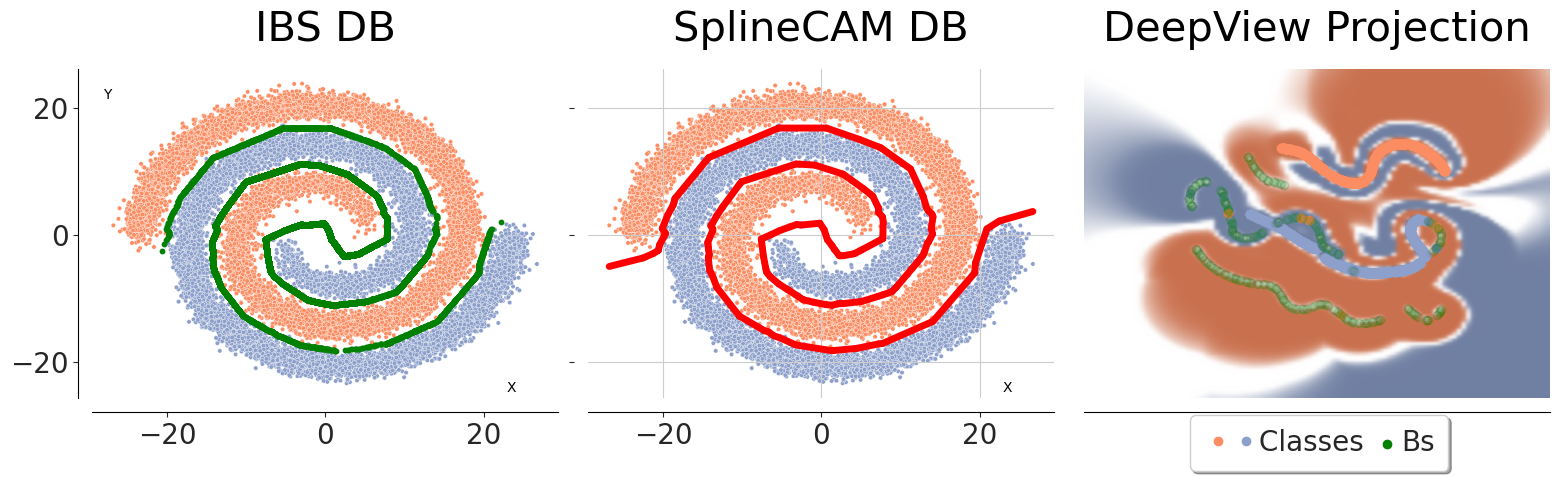

In [32]:
if n_features == 2:
  cols=["X","Y","label"]
  fig, ((ax0,ax1,ax2)) = plt.subplots(1,3, figsize=(16,5));
  sns.set_style("white")

  rc = {
        'figure.dpi': 500,
        'axes.facecolor':'white',
        'axes.grid' : True,
        'grid.color': '.8',
        'font.size' : 20,
		'axes.titlesize': 30,   # fontsize of the axes title
		'axes.labelsize': "medium",  # fontsize of the x any y labels
		'font.size' : 20,
		'axes.titlepad':20}
  plt.rcParams.update(rc)
  custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

  deepview.show(baseline = True, last = to_deep_len*2 ,bs_color = 'g', fig=fig, ax=ax2, alpha_bs = .01)
  df = pd.DataFrame(dataloader.__dict__['dataset'].numpy(), columns=cols)
  if n_features == 2:
    sns.scatterplot(df, x="X",y="Y", hue="label", s=10, ax=ax0, palette=sns.color_palette("Set2")[1:3])
    sns.scatterplot(df, x="X",y="Y", hue="label" ,s=10, ax=ax1, palette=sns.color_palette("Set2")[1:3])

  ax0.scatter(*bs_arr[:,:n_features].T, zorder=10000000000, c='g', s=10, alpha=1)

  ax1.set_xlim(ax0.get_xlim())
  ax1.set_ylim(ax0.get_ylim())
  ax1.set_yticklabels([])
  ax1.set_ylabel("")

  for each in endpoints:
      if each is not None:
          ax1.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=5, alpha=1)
  
  ax0.legend([],frameon=False)
  ax1.legend([],frameon=False)
  ax0.set_title("IBS DB")
  ax1.set_title("SplineCAM DB")
  ax2.set_title("DeepView Projection")
  sns.despine(offset=10, trim=False)
  sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False, offset=10, trim=False)
  sns.despine(ax=ax2, top=True, right=False, left=True, bottom=False, offset=10, trim=False)
  
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_xticklabels([])
  ax2.set_yticklabels([])
  ax2.set_xlabel("")
  ax2.set_ylabel("")

  h, l = ax2.get_legend_handles_labels()
  
  fig.legend(handles=h, handler_map={PathCollection : HandlerPathCollection(update_func= update),\
    plt.Line2D : HandlerLine2D(update_func = update)},\
      labels=["","Classes ", "Bs"], loc='lower center',  bbox_to_anchor=[0.837, -0.01],
      fancybox=True, shadow=True, ncol=3, fontsize="medium",handlelength=1,borderpad=0.5, handletextpad=0.,columnspacing=0)
  ax2.legend([],frameon=False)
  # ax1.set_ylabel("Z", rotation='horizontal', y=0.90, labelpad=-50)
  ax0.set_ylabel("Y", rotation='horizontal', y=0.90, labelpad=-70)
  ax0.set_xlabel("X", rotation='horizontal', x =0.90, labelpad=-50)
  ax1.set_xlabel("X", rotation='horizontal', x=0.90, labelpad=-50)
  ax.grid(True);ax1.grid(True)
  plt.tight_layout()



## Umap

In [33]:
import umap
if n_features == 3:
    in_data = np.concatenate([class_0_data,class_1_data])
    labels = np.zeros(in_data.shape[0]+bs_arr.shape[0])
    labels[len(class_0_data):] = 1
    labels[len(class_0_data)+len(class_1_data):] = 2

    reducer = umap.UMAP(50,random_state=seed, init="pca")
    reducer.fit(np.concatenate([in_data,bs_arr]))

    embedding = reducer.transform(np.concatenate([in_data, bs_arr]))

In [34]:

if n_features == 3:
    fig, ((ax0,ax2)) = plt.subplots(1,2, figsize=(20,10)); cols=["X","Y", "Z","label"]
    sns.set_style("white")

    rc = {
        "figure.dpi": 500,
        'figure.figsize':(16,8),
        'axes.facecolor':'white',
        'axes.grid' : True,
        'grid.color': '.8',
        "axes.titlesize": 30,   # fontsize of the axes title
        "axes.labelsize": "medium",  # fontsize of the x any y labels
        'font.size' : 20,
        'axes.titlepad':20}
    plt.rcParams.update(rc)
    custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

    deepview.show(baseline = True, last = to_deep_len*2 ,bs_color = 'g', fig=fig, ax=ax2, alpha_bs=0.05)
    df = pd.DataFrame(dataloader.__dict__['dataset'].numpy(), columns=cols)

    ax0.scatter(embedding[:len(in_data), 0], embedding[:len(in_data), 1], c=labels[:len(in_data)], \
                cmap= mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)]), s=5)
    ax0.scatter(embedding[len(in_data):, 0], embedding[len(in_data):, 1], c=labels[len(in_data):], \
                cmap= mcolors.ListedColormap(["green"]), s=5, alpha=.5)


    ax0.legend([],frameon=False)

    t0 = ax0.set_title("UMAP projection")

    ax2.set_title("DeepView Projection")
    sns.despine(offset=10, trim=False)

    sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False, offset=10, trim=False)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    h,l = ax2.get_legend_handles_labels()
    ax2.legend([],frameon=False)
    fig.legend(handles=h, handler_map={PathCollection : HandlerPathCollection(update_func= update),\
                                                    plt.Line2D : HandlerLine2D(update_func = update)},\
                labels=["","Classes ", "Bs"], loc='lower center',  bbox_to_anchor=[0.41, +0.02],
                fancybox=True, shadow=True, ncol=3, fontsize="medium",handlelength=1,borderpad=0.5, handletextpad=0.,columnspacing=0)

    plt.tight_layout()
